# Topic Modelling For Business

---



### *Introduction to the Dataset*

Importing Modules

In [1]:
# Importing modules
import pandas as pd
import os
os.chdir('..')

import numpy as np
import re, nltk, spacy, gensim

import logging
import warnings
warnings.filterwarnings('ignore')  

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

In [2]:
# Upload .csv file
from google.colab import files
uploaded = files.upload()

Saving DigitalEconomyDatasetTM.csv to DigitalEconomyDatasetTM.csv


In [3]:
# Store dataset in a Pandas Dataframe
import io
df = pd.read_csv(io.BytesIO(uploaded['DigitalEconomyDatasetTM.csv']))

Read dataset

In [4]:
df.head()

,Authors,Title,Year,Abstract,Keywords
0,"Nguyen Q.K., Dang Q.V.",Blockchain Technology - Opportunities for Emer...,2018,The recent major scientific conferences on the...,blockchain; digitaltechnology; distributed dia...
1,"Melnyk M., Korcelli-Olejniczak E., Chorna N., ...",Development of regional IT clusters in Ukraine...,2018,Introduction. Accelerated introduction of mode...,Country’s Innovation Ecosystem; Development of...
2,"Reisman R., Bertini M.",A novel architecture to monetize digital offer...,2018,As commerce continues to shift to the digital ...,Digital goods; Electronic commerce; Price disc...
3,"Bertola P., Teunissen J.",Fashion 4.0. Innovating fashion industry throu...,2018,Purpose: The on-going transition of societies ...,Design driven companies; Digital transformatio...
4,Moreno de la Santa J.G.-S.,The travel industry in 2018 – setting the scen...,2018,Purpose: The purpose of the paper is to identi...,China; Digital transformation; Global economy;...


In [5]:
print(df.shape)

(2488, 5)


###  *Data cleaning and preparation*

In [6]:
df['Abstract'].head()

0    The recent major scientific conferences on the...
1    Introduction. Accelerated introduction of mode...
2    As commerce continues to shift to the digital ...
3    Purpose: The on-going transition of societies ...
4    Purpose: The purpose of the paper is to identi...
Name: Abstract, dtype: object

In [7]:
df.drop(df[df['Abstract'] == '[No abstract available]'].index, inplace= True)

In [8]:
print(df.shape)

# Note the drop in number of rows

(2423, 5)


In [9]:
import re

# Remove punctuation
df['p_abstract'] = df['Abstract'].map(lambda x: re.sub('[,\.!?]','',x))

# Convert the titles to lowercase
df['p_abstract'] = df['p_abstract'].map(lambda x: x.lower())

# Print out the first rows of papers
df['p_abstract'].head()

0    the recent major scientific conferences on the...
1    introduction accelerated introduction of moder...
2    as commerce continues to shift to the digital ...
3    purpose: the on-going transition of societies ...
4    purpose: the purpose of the paper is to identi...
Name: p_abstract, dtype: object

###  *Exploratory Analysis with WordCloud*

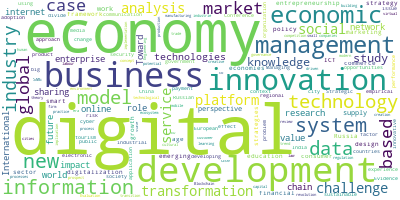

In [10]:
#For Title

# Import the wordcloud library
from wordcloud import WordCloud

# Join the different titles together.
long_string = ','.join(list(df['Title'].values))

# Generate the word cloud
wordcloud = WordCloud(background_color="white",
                       max_words=500,
                       contour_width=3,
                       contour_color='steelblue',
                       collocations=False).generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

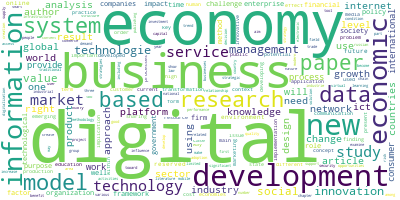

In [11]:
#For Abstract
#Print only top 200 words

# Join the different processed abstracts together.
long_string = ','.join(list(df['p_abstract'].values))

# Generate the word cloud
wordcloud2 = WordCloud(background_color="white",
                       max_words=200,
                       contour_width=3,
                       contour_color='steelblue',
                       collocations=False).generate(long_string)

# Visualize the word cloud
wordcloud2.to_image()

Remove the commonly used words (or irrelevant according to the context) from the wordcloud

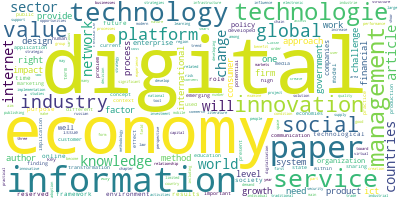

In [12]:
## Remove STOPWORDS taking reference from previous wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["research", "economic", "study", "data", "development", "result", "analysis", "model", 
                 "based", "using", "new", "market", "business", "system", "use"])

# Generate the word cloud
wordcloud3 = WordCloud(stopwords= stopwords,
                       background_color="white",
                       max_words=200,
                       contour_width=3,
                       contour_color='steelblue',
                       collocations=False).generate(long_string)

# Visualize the word cloud
wordcloud3.to_image()

### *Prepare data for Topic Modelling*

Step 1: Split sentences to words

In [13]:
%%time
import gensim
from gensim.utils import simple_preprocess
def sent_to_words (sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data=df.p_abstract.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['the', 'recent', 'major', 'scientific', 'conferences', 'on', 'the', 'innovatube', 'frontier', 'ifs', 'have', 'focused', 'on', 'four', 'areas', 'of', 'pioneering', 'technologies', 'including', 'artificial', 'intelligence', 'internet', 'of', 'things', 'blockchain', 'and', 'augmented', 'reality', 'virtual', 'reality', 'blockchain', 'has', 'gained', 'lot', 'of', 'attention', 'because', 'not', 'only', 'it', 'is', 'the', 'technology', 'that', 'has', 'created', 'the', 'fever', 'of', 'the', 'bitcoin', 'and', 'ethereum', 'digital', 'coins', 'but', 'also', 'because', 'of', 'its', 'great', 'potentials', 'that', 'can', 'change', 'the', 'nature', 'of', 'the', 'real', 'world', 'and', 'in', 'everyone', 'lives', 'there', 'have', 'been', 'various', 'studies', 'on', 'blockchain', 'however', 'in', 'reality', 'the', 'percentage', 'of', 'people', 'who', 'understand', 'blockchain', 'remain', 'minute', 'this', 'paper', 'will', 'highlight', 'the', 'important', 'role', 'of', 'blockchain', 'technology', 'in',

Step 2: Build N-grams

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)                                                 # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)   
# Faster way to get a sentence formatted as a bigram or trigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Step 3: Remove Stopwords

In [15]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['research', 'study', 'data', 'development', 'result', 'analysis', 'model', 
                 'based', 'using', 'new', 'market', 'business', 'system', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
      doc= nlp(" ".join(sent))
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Step 4: Lemmatize

In [16]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Lemmatize keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags= ['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['recent', 'major', 'scientific', 'conference', 'focus', 'area', 'pioneer', 'technology', 'include', 'artificial_intelligence', 'internet', 'thing', 'blockchain', 'augmented_reality', 'virtual', 'reality', 'blockchain', 'gain', 'lot', 'attention', 'technology', 'create', 'fever', 'bitcoin', 'ethereum', 'coin', 'also', 'great', 'potential', 'change', 'nature', 'real', 'world', 'live', 'various', 'study', 'blockchain', 'however', 'reality', 'percentage', 'people', 'understand', 'remain', 'minute', 'paper', 'highlight', 'important', 'role', 'blockchain', 'technology', 'future', 'world', 'especially', 'develop', 'country']]


Step 5: Build Corpora

In [17]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 4), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 3), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2)]]


### *Build Topic Model*

In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            random_state=123,
                                            chunksize=100,
                                            passes=10,
                                            alpha=0.01,
                                            eta='auto',
                                            iterations=400,
                                            per_word_topics=True)

In [19]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"economy" + 0.015*"work" + 0.013*"economic" + 0.010*"social" + '
  '0.010*"change" + 0.009*"share" + 0.008*"global" + 0.007*"people" + '
  '0.007*"digital" + 0.007*"cyber"'),
 (1,
  '0.014*"big" + 0.014*"millennial" + 0.013*"analytic" + 0.012*"leader" + '
  '0.011*"leadership" + 0.011*"transport" + 0.010*"health" + 0.008*"person" + '
  '0.007*"can" + 0.007*"system"'),
 (2,
  '0.035*"online" + 0.031*"consumer" + 0.017*"addition" + 0.015*"pay" + '
  '0.012*"previous" + 0.012*"consist" + 0.012*"user" + 0.010*"product" + '
  '0.010*"circular" + 0.009*"web"'),
 (3,
  '0.019*"digital" + 0.014*"economy" + 0.012*"paper" + 0.010*"platform" + '
  '0.009*"service" + 0.009*"provide" + 0.008*"approach" + 0.008*"process" + '
  '0.007*"technology" + 0.007*"develop"'),
 (4,
  '0.036*"marketing" + 0.027*"information" + 0.022*"public" + 0.022*"medium" + '
  '0.021*"government" + 0.020*"citizen" + 0.018*"chinese" + 0.014*"generation" '
  '+ 0.014*"construction" + 0.013*"digitization"'),
 (5

In [20]:
from gensim.models import CoherenceModel

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. Lower value is preferred.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score u_mass: ', coherence_lda )


Perplexity:  -7.8572895288696225

Coherence Score:  0.33813053427894463

Coherence Score u_mass:  -4.071330317407208


### *Visualize model*

In [21]:
# Visualize the topics
!pip install -U pyLDAvis
import pyLDAvis.gensim


     |████████████████████████████████| 1.6MB 2.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=68be75153cbecf49b036946a7eb77d25fbe750f6de6c4d3f42c559b213febaab
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [22]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.127655  0.002241       1        1  31.408183
0     -0.017133 -0.125550       2        1  15.074730
8     -0.164118  0.066486       3        1  13.777680
7     -0.065475 -0.117434       4        1  10.790955
5     -0.148319  0.077220       5        1  10.399568
6      0.066945 -0.237341       6        1   4.325312
4     -0.048659  0.115861       7        1   4.258117
2      0.187132 -0.031299       8        1   3.807182
1      0.256961  0.127773       9        1   3.369768
9      0.060322  0.122042      10        1   2.788505, topic_info=             Term         Freq        Total Category  logprob  loglift
390        online   695.000000   695.000000  Default  30.0000  30.0000
119   information  1330.000000  1330.000000  Default  29.0000  29.0000
136    management  1043.000000  1043.000000  Default  28.0000  28.0000
309      industry  1045.000000  1045.000000  Default  27.0000  27.0000
90       economic  1571.000000  1571.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
818      creative    30.314501    93.970144  Topic10  -5.3557   2.4483
2536          act    30.245897   111.182441  Topic10  -5.3580   2.2779
96    environment    32.717752   478.614045  Topic10  -5.2794   0.8967
612   possibility    30.342904   171.693502  Topic10  -5.3548   1.8465
91        economy    32.641296  3350.587486  Topic10  -5.2818  -1.0516

[589 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1869      1  0.994864          able
4094      7  0.972866        abroad
243       1  0.996344      academic
2371     10  0.992087  acceleration
635       1  0.104706        access
...     ...       ...           ...
1178      7  0.003328         would
1178      8  0.063236         would
1178      9  0.009985         would
1178     10  0.003328         would
1777      7  0.971875         yield

[1483 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 9, 8, 6, 7, 5, 3, 2, 10])

References

Liu, L., Tang, L., Dong, W., Yao, S., & Zhou, W. (2016). An overview of topic modeling and its current applications in bioinformatics. SpringerPlus, 5(1), 1608. https://doi.org/10.1186/s40064-016-3252-8)